In [1]:
import torch
import triton
import triton.language as tl
import os
from copy import deepcopy
import math
os.environ['TRITON_PRINT_AUTOTUNING'] = '1'
triton.__version__

'3.2.0'

# triton code

In [ ]:
# @triton.autotune([triton.Config({'BLOCK_SIZE_N': bsn}, num_stages=ns, num_warps=nw)
#                  for bsn in [16, 32, 64]
#                  for ns in [1,2,4]
#                  for nw in [4,8]
#                  ], key=['B', 'H', 'FP32'])
@triton.jit
def _lighting_attention_encode_kernel(QKV, KV, Y, SLOPE_RATE, NUM_PADDDINGS,
                                    qkv_sb, qkv_sn, qkv_sh, qkv_sd,
                                    kv_sb, kv_sh, kv_sd, kv_se,
                                    y_sb, y_sh, y_sn, y_sd,
                                    B, N, H, D:tl.constexpr, FP32:tl.constexpr,
                                    BLOCK_SIZE_N: tl.constexpr,
                                    ):
    off_b = tl.program_id(0)
    off_h = tl.program_id(1)

    QKV += off_b * qkv_sb + off_h * qkv_sh
    KV += off_b * kv_sb + off_h * kv_sh
    Y += off_b * y_sb + off_h * y_sh
    SLOPE_RATE += off_h
    NUM_PADDDINGS += off_b
    dd = tl.arange(0, D)
    nn = tl.arange(0, BLOCK_SIZE_N)

    num_paddings = tl.load(NUM_PADDDINGS)
    q_ptrs = QKV + (nn[:, None] + num_paddings) * qkv_sn + dd[None, :]
    k_ptrs = QKV + (nn[None, :] + num_paddings) * qkv_sn + dd[:, None] + D
    kv_ptrs = KV + dd[:, None] * kv_sd + dd[None, :]
    y_pts = Y + (nn[:, None] + num_paddings) * y_sn + dd[None, :]

    slope_rate = tl.load(SLOPE_RATE).to(tl.float32)

    array = (nn + 1)
    q_decay = tl.exp(-1. * slope_rate * array)[:, None]
    k_decay = tl.exp(-1. * slope_rate * (BLOCK_SIZE_N - array))[None, :]
    index = array[:, None] - array[None, :]
    s_index = slope_rate * index
    s_index = tl.where(index >= 0, -s_index, float('-inf'))
    diag_decay = tl.exp(s_index)

    if FP32:
        dtype = tl.float32
    else:
        dtype = tl.bfloat16
    kv = tl.zeros((D, D), dtype=tl.float32)
    
    for start_n in tl.range(num_paddings, N, BLOCK_SIZE_N):
        mask_nn = (nn + start_n) < N  
        m = tl.minimum(N-start_n, BLOCK_SIZE_N)
        if m < BLOCK_SIZE_N:
            k_decay = tl.exp(-1. * slope_rate * (m - array))[None, :]
            
        q = tl.load(q_ptrs, mask=mask_nn[:, None], other=0.).to(dtype)
        k = tl.load(k_ptrs, mask=mask_nn[None, :], other=0.).to(dtype)
        v = tl.load(q_ptrs + 2*D, mask=mask_nn[:, None], other=0.).to(dtype)

        qkv_none_diag = tl.dot((q * q_decay).to(dtype), kv.to(dtype))

        qk = tl.dot(q, k) * diag_decay
        qkv_diag = tl.dot(qk.to(dtype), v)
        y = qkv_diag + qkv_none_diag
        block_decay = tl.exp(-1. * slope_rate * m)
        kv = kv * block_decay + tl.dot((k * k_decay).to(v.dtype), v)
        # kv = tl.dot(tl.permute(k, (1,0)), k)
        
        tl.store(y_pts, y, mask=mask_nn[:, None])

        q_ptrs += BLOCK_SIZE_N * qkv_sn
        y_pts += BLOCK_SIZE_N * y_sn
        k_ptrs += BLOCK_SIZE_N * qkv_sn
    tl.store(kv_ptrs, kv)

# @triton.autotune([triton.Config({}, num_stages=ns, num_warps=nw)
#                 #  for bsn in [32, 64, 128]
#                  for ns in [1,2,3,4]
#                  for nw in [2,4,8]
#                  ], key=['B', 'N', 'H'])
@triton.jit
def _lighting_attention_decode_kernel(QKV, KV, Y, SLOPE_RATE,
                                    qkv_sb, qkv_sn, qkv_sh, qkv_sd,
                                    kv_sb, kv_sh, kv_sd, kv_se,
                                    y_sb, y_sh, y_sn, y_sd,
                                    B, N, H, D:tl.constexpr, FP32:tl.constexpr,
                                    ):
    off_b = tl.program_id(0)
    off_h = tl.program_id(1)

    QKV += off_b * qkv_sb + off_h * qkv_sh
    KV += off_b * kv_sb + off_h * kv_sh
    Y += off_b * y_sb + off_h * y_sh
    SLOPE_RATE += off_h
    dd = tl.arange(0, D)

    q_ptrs = QKV + dd
    kv_ptrs = KV + dd[:, None] * kv_sd + dd[None, :]
    y_ptrs = Y + dd

    slope_rate = tl.load(SLOPE_RATE).to(tl.float32)
    ratio = tl.exp(-1. * slope_rate)

    if FP32:
        dtype = tl.float32
    else:
        dtype = tl.bfloat16
    kv = tl.load(kv_ptrs).to(dtype)
    q = tl.load(q_ptrs).to(dtype)
    k = tl.load(q_ptrs+D) .to(dtype)
    v = tl.load(q_ptrs + 2*D).to(dtype)

    kv = ratio * kv + k[:, None] * v[None, :]
    y = tl.sum(q[:, None] * kv, axis=0)
    tl.store(kv_ptrs, kv)
    tl.store(y_ptrs, y)


def lighting_attention_encode(qkv, slope_rate, attention_mask=None, fp32=False):
    # b, n, h, d
    b, n, h, d3 = qkv.shape
    d = d3 // 3
    assert math.log2(d).is_integer(), 'd must be power of 2'
    slope_rate = slope_rate.squeeze()
    kv = torch.empty(b, h, d, d).to(torch.float32).to(qkv.device)
    y = torch.empty(b, h, n, d, device=qkv.device, dtype=qkv.dtype)
    if attention_mask is not None:
        assert attention_mask[-1, :].min().values != 0, 'please use left_padding'
        num_paddings = n - attention_mask.sum(-1)
    else:
        num_paddings = torch.full((b,), 0, device=qkv.device, dtype=torch.int32)
    
    grids = (b, h)

    _lighting_attention_encode_kernel[grids](qkv, kv, y, slope_rate, num_paddings,
                                            *qkv.stride(),
                                            *kv.stride(),
                                            *y.stride(),
                                            b, n, h, d, fp32,
                                            BLOCK_SIZE_N=32,
                                            num_warps=8, num_stages=4 if fp32 else 1,
                                            )
    return y, kv

def lighting_attention_decode(qkv, slope_rate, kv, fp32=False):
    # b, n, h, d
    b, n, h, d3 = qkv.shape
    assert n == 1, 'decoing phase need n=1'
    d = d3 // 3
    slope_rate = slope_rate.squeeze()
    y = torch.empty(b, h, n, d, device=qkv.device, dtype=qkv.dtype)

    grids = (b, h)

    _lighting_attention_decode_kernel[grids](qkv, kv, y, slope_rate,
                                            *qkv.stride(),
                                            *kv.stride(),
                                            *y.stride(),
                                            b, n, h, d, fp32,
                                            num_warps=8, num_stages=1,
                                            )
    return y, kv

def triton_lighting_attention(qkv, slope_rate, past_key_value=None, attention_mask=None, fp32=False):
    if past_key_value is None:
        y, kv = lighting_attention_encode(qkv, slope_rate, attention_mask, fp32)
    else:
        y, kv = lighting_attention_decode(qkv, slope_rate, past_key_value, fp32)
    return y, kv


# torch code

In [3]:
BLOCK = 256
def torch_lighting_attention(qkv, slope_rate, past_key_value=None, attention_mask=None):
    n = qkv.size(1)
    q, k, v = torch.split(qkv, [qkv.size(-1)//3] * 3, dim=3)
    # [b, h, l, d]
    q = q.transpose(1, 2)
    k = k.transpose(1, 2)
    v = v.transpose(1, 2)

    if past_key_value is None:
        offset = q.shape[-2]
    else:
        offset = 1

    # for align with metaseq
    ratio = torch.exp(-slope_rate)

    # only use for the first time
    if past_key_value is None:
        slope_rate = slope_rate.to(torch.float32)
        if attention_mask is not None:
            v = v.masked_fill((1 - attention_mask).unsqueeze(1).unsqueeze(-1).to(torch.bool), 0)
        # print(v[0, 0, :32])
        NUM_BLOCK = (n + BLOCK - 1) // BLOCK
        b, h, n, d = q.shape
        e = v.shape[-1]
        # other
        array = torch.arange(BLOCK).to(q) + 1
        q_decay = torch.exp(-slope_rate * array.reshape(-1, 1)) # h, bn, 1 
        k_decay = torch.exp(-slope_rate * (BLOCK - array.reshape(-1, 1)))
        index = array[:, None] - array[None, :]
        s_index = slope_rate * index[
            None,
            None,
        ]
        s_index = torch.where(index >= 0, -s_index, float("-inf"))
        diag_decay = torch.exp(s_index)

        kv = torch.zeros(b, h, d, e).to(torch.float32).to(q.device)
        output = torch.empty((b, h, n, e), dtype=q.dtype, device=q.device)
        for i in range(NUM_BLOCK):
            si = i * BLOCK
            ei = min(si + BLOCK, n)
            m = ei - si
            qi = q[:, :, si:ei].contiguous()
            ki = k[:, :, si:ei].contiguous()
            vi = v[:, :, si:ei].contiguous()
            qkv_none_diag = torch.matmul(qi * q_decay[:, :m], kv).to(torch.float32)

            # diag
            qk = torch.matmul(qi, ki.transpose(-1, -2)).to(torch.float32) * diag_decay[:, :, :m, :m]
            qkv_diag = torch.matmul(qk, vi.to(torch.float32))
            block_decay = torch.exp(-slope_rate * m)
            output[:, :, si:ei] = qkv_none_diag + qkv_diag
            kv = block_decay * kv + torch.matmul((ki * k_decay[:, -m:]).transpose(-1, -2).to(vi.dtype), vi)
    else:
        kv = past_key_value
        output = []
        for i in range(n):
            kv = ratio * kv + torch.einsum(
                "... n d, ... n e -> ... d e",
                k[:, :, i:i + 1],
                v[:, :, i:i + 1],
            )
            qkv = torch.einsum("... n e, ... e d -> ... n d", q[:, :, i:i + 1], kv.to(q.dtype))
            output.append(qkv)
        output = torch.concat(output, dim=-2)
    return output, kv


# 精度测试
- 这个attention真的离谱，精度差很多
- 原始代码中既有fp32也有bf16的矩阵乘

In [4]:
dtype = torch.bfloat16
device = 'cuda'
b, n, h, d = 8, 1020, 64, 128
qkv = torch.randn(b, n, h, d*3, device=device, dtype=dtype)
slope_rate = torch.rand(h, 1, 1, device=device, dtype=torch.float32)
gold_qkv = torch.rand_like(qkv, dtype=torch.float32).copy_(qkv)
attn_mask = torch.ones(b, n, device=device, dtype=torch.int32)
attn_mask[:, :30] = 0 

In [6]:
x1, x2 = torch_lighting_attention(qkv, slope_rate, attention_mask=attn_mask)
y1, y2 = triton_lighting_attention(qkv, slope_rate, attention_mask=attn_mask, fp32=True)
z1, z2 = torch_lighting_attention(gold_qkv, slope_rate, attention_mask=attn_mask)
print((x1-z1).abs().max(), (x1-z1).abs().mean())
print((y1-z1).abs().max(), (y1-z1).abs().mean())
print((x2-z2).abs().max(), (x2-z2).abs().mean())
print((y2-z2).abs().max(), (y2-z2).abs().mean())

Autotuning kernel _lighting_attention_encode_kernel with config BLOCK_SIZE_N: 16, num_warps: 4, num_ctas: 1, num_stages: 1, maxnreg: None
Autotuning kernel _lighting_attention_encode_kernel with config BLOCK_SIZE_N: 16, num_warps: 8, num_ctas: 1, num_stages: 1, maxnreg: None
Autotuning kernel _lighting_attention_encode_kernel with config BLOCK_SIZE_N: 16, num_warps: 4, num_ctas: 1, num_stages: 2, maxnreg: None
Autotuning kernel _lighting_attention_encode_kernel with config BLOCK_SIZE_N: 16, num_warps: 8, num_ctas: 1, num_stages: 2, maxnreg: None
Autotuning kernel _lighting_attention_encode_kernel with config BLOCK_SIZE_N: 16, num_warps: 4, num_ctas: 1, num_stages: 4, maxnreg: None
Autotuning kernel _lighting_attention_encode_kernel with config BLOCK_SIZE_N: 16, num_warps: 8, num_ctas: 1, num_stages: 4, maxnreg: None
Autotuning kernel _lighting_attention_encode_kernel with config BLOCK_SIZE_N: 32, num_warps: 4, num_ctas: 1, num_stages: 1, maxnreg: None
Autotuning kernel _lighting_attent

In [15]:
dtype = torch.bfloat16
device = 'cuda'
b, n, h, d = 8, 1, 64, 128
qkv = torch.randn(b, n, h, d*3, device=device, dtype=dtype)
kv =  torch.randn(b, h, d, d, dtype=torch.float32, device=device)
slope_rate = torch.rand(h, 1, 1, device=device, dtype=dtype)
gold_qkv = torch.rand_like(qkv, dtype=torch.float32).copy_(qkv)

In [16]:
x1, x2 = torch_lighting_attention(qkv, slope_rate, deepcopy(kv))
y1, y2 = lighting_attention_decode(qkv, slope_rate, deepcopy(kv), fp32=True)
z1, z2 = torch_lighting_attention(gold_qkv, slope_rate, deepcopy(kv))
print((x1-z1).abs().max(), (x1-z1).abs().mean())
print((y1-z1).abs().max(), (y1-z1).abs().mean())
print((x2-z2).abs().max(), (x2-z2).abs().mean())
print((y2-z2).abs().max(), (y2-z2).abs().mean())

tensor(0.3999, device='cuda:0') tensor(0.0254, device='cuda:0')
tensor(0.2506, device='cuda:0') tensor(0.0162, device='cuda:0')
tensor(0.0312, device='cuda:0') tensor(0.0009, device='cuda:0')
tensor(0.0094, device='cuda:0') tensor(0.0006, device='cuda:0')


# 性能测试
- encode 阶段bf16比fp32快一倍

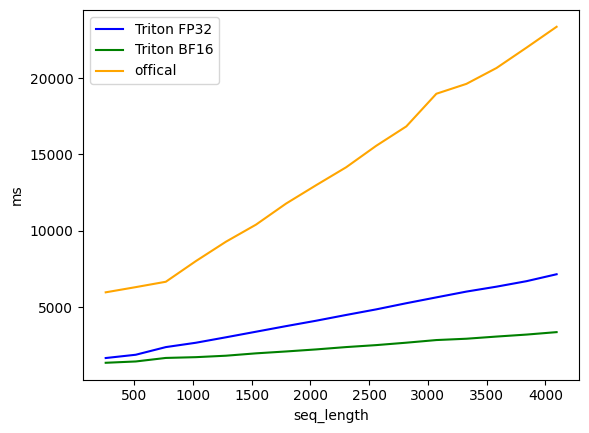

lighting attention encode phase:
    seq_length  Triton FP32  Triton BF16       offical
0        256.0  1653.897607  1342.783988   5961.299229
1        512.0  1869.561577  1429.142416   6302.335835
2        768.0  2370.848083  1660.384059   6654.694271
3       1024.0  2656.089640  1711.071968   8009.126186
4       1280.0  3013.446379  1806.246400   9279.440117
5       1536.0  3379.334354  1961.536026  10399.312019
6       1792.0  3745.955181  2085.024118  11778.944016
7       2048.0  4099.679852  2219.167948  12984.339046
8       2304.0  4478.118277  2372.639990  14160.915375
9       2560.0  4844.198418  2501.423955  15568.684959
10      2816.0  5247.417545  2659.705591  16837.772942
11      3072.0  5630.527973  2832.623911  18978.947449
12      3328.0  6009.948874  2919.631910  19627.318001
13      3584.0  6332.425594  3061.651182  20666.637421
14      3840.0  6692.560101  3191.929626  22003.308868
15      4096.0  7146.534634  3352.195239  23369.216156


In [4]:

torch.cuda.empty_cache()
@triton.testing.perf_report(
    triton.testing.Benchmark(
        x_names=['seq_length'],  # argument names to use as an x-axis for the plot
        x_vals=[256 * i for i in range(1, 16+1, 1)],  # different possible values for `x_name`
        line_arg='provider',  # argument name whose value corresponds to a different line in the plot
        line_vals=['Triton FP32', 'Triton BF16', 'offical'],  # possible values for `line_arg``
        line_names=[
            "Triton FP32",
            'Triton BF16',
            "offical",
        ],  # label name for the lines
        styles=[('blue', '-'), ('green', '-'), ('orange', '-')],  # line styles
        ylabel="ms",  # label name for the y-axis
        plot_name="lighting attention encode phase",  # name for the plot. Used also as a file name for saving the plot.
        args={'h': 64, 'd': 128, 'b':4}
        # args={'bs': 2, 'num_head': 32, 'rope_head_dim': 32, 
        #       'nope_head_dim': 64, 'kv_lora_rank': 256},  # values for function arguments not in `x_names` and `y_name`
    ))
def benchmark(b,seq_length,h,d, provider):
    n = seq_length
    dtype = torch.bfloat16
    device = 'cuda'
    qkv = torch.randn(b, n, h, d*3, device=device, dtype=dtype)
    slope_rate = torch.rand(h, 1, 1, device=device, dtype=dtype)
    attn_mask = torch.ones(b, n, device=device, dtype=torch.int32)
    attn_mask[:, :n//10] = 0 
    stream = torch.cuda.Stream()
    torch.cuda.set_stream(stream)
    quantiles = [0.1, 0.3, 0.7]
    if provider == 'Triton FP32':
        ms, *_ = triton.testing.do_bench(lambda: triton_lighting_attention(qkv, slope_rate, attention_mask=attn_mask, fp32=True), rep=100, quantiles=quantiles)
    if provider == 'Triton BF16':
        ms, *_ = triton.testing.do_bench(lambda: triton_lighting_attention(qkv, slope_rate, attention_mask=attn_mask), rep=100, quantiles=quantiles)
    if provider == 'offical':
        ms, *_ = triton.testing.do_bench(lambda: torch_lighting_attention(qkv, slope_rate, attention_mask=attn_mask), rep=100, quantiles=quantiles)

    return ms * 1e3
benchmark.run(show_plots=True, print_data=True)


- decode阶段fp32和bf16差不多，使用fp32即可

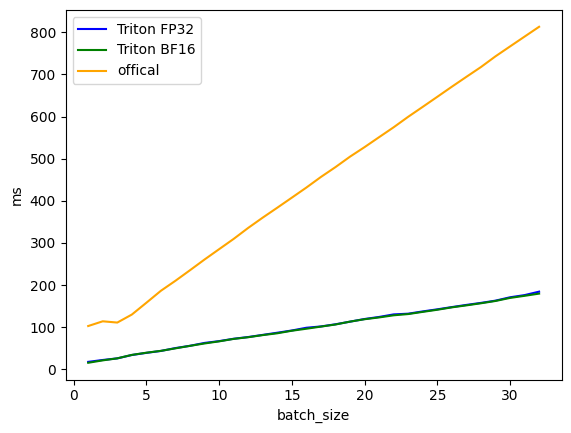

lighting attention decode phase:
    batch_size  Triton FP32  Triton BF16     offical
0          1.0    17.679894    15.502415  102.734769
1          2.0    22.144053    21.240263  113.972269
2          3.0    25.959003    26.018924  110.972138
3          4.0    33.943456    34.198344  129.963535
4          5.0    39.029889    39.405599  158.012074
5          6.0    43.612794    43.826936  186.480457
6          7.0    50.439504    49.780541  210.226061
7          8.0    55.848381    55.696159  235.247119
8          9.0    62.636197    61.370503  260.674923
9         10.0    66.904972    66.366320  285.147227
10        11.0    72.525724    72.175794  309.538715
11        12.0    76.619106    76.191862  335.664604
12        13.0    81.724115    81.206252  360.104120
13        14.0    86.863891    85.546667  383.613168
14        15.0    92.126074    91.574532  407.466493
15        16.0    98.672422    96.329078  431.435091
16        17.0   101.767729   101.404885  456.599662
17        18.

In [5]:

torch.cuda.empty_cache()
@triton.testing.perf_report(
    triton.testing.Benchmark(
        x_names=['batch_size'],  # argument names to use as an x-axis for the plot
        x_vals=[i for i in range(1, 32+1, 1)],  # different possible values for `x_name`
        line_arg='provider',  # argument name whose value corresponds to a different line in the plot
        line_vals=['Triton FP32', 'Triton BF16', 'offical'],  # possible values for `line_arg``
        line_names=[
            "Triton FP32",
            'Triton BF16',
            "offical",
        ],  # label name for the lines
        styles=[('blue', '-'), ('green', '-'), ('orange', '-')],  # line styles
        ylabel="ms",  # label name for the y-axis
        plot_name="lighting attention decode phase",  # name for the plot. Used also as a file name for saving the plot.
        args={'h': 64, 'd': 128, 'n':1}
        # args={'bs': 2, 'num_head': 32, 'rope_head_dim': 32, 
        #       'nope_head_dim': 64, 'kv_lora_rank': 256},  # values for function arguments not in `x_names` and `y_name`
    ))
def benchmark(batch_size,n,h,d, provider):
    b = batch_size
    dtype = torch.bfloat16
    device = 'cuda'
    qkv = torch.randn(b, n, h, d*3, device=device, dtype=dtype)
    kv =  torch.randn(b, h, d, d, dtype=torch.float32, device=device)
    slope_rate = torch.rand(h, 1, 1, device=device, dtype=dtype)
    stream = torch.cuda.Stream()
    torch.cuda.set_stream(stream)
    quantiles = [0.5, 0.3, 0.7]
    if provider == 'Triton FP32':
        ms = triton.testing.do_bench(lambda: triton_lighting_attention(qkv, slope_rate, kv, fp32=True), rep=100)
    if provider == 'Triton BF16':
        ms = triton.testing.do_bench(lambda: triton_lighting_attention(qkv, slope_rate, kv), rep=100)
    if provider == 'offical':
        ms = triton.testing.do_bench(lambda: torch_lighting_attention(qkv, slope_rate, kv), rep=100)

    return ms * 1e3
benchmark.run(show_plots=True, print_data=True)
